In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/FYPDATA.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish') 

finish


In [25]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os 

In [26]:
num_classes = 6
img_rows,img_cols = 48,48
batch_size =32

In [27]:
train_data_dir = '/content/FYPDATA/train'
validation_data_dir = '/content/FYPDATA/validation'

In [28]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					width_shift_range=0.4,
					height_shift_range=0.4,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(img_rows,img_cols),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(img_rows,img_cols),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

Found 26017 images belonging to 6 classes.
Found 6072 images belonging to 6 classes.


In [30]:
model = Sequential()

In [31]:
# Block-1

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',strides=(1,1),input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-3

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(512,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block-5

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

In [32]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
activation_13 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)       

In [33]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [34]:
checkpoint = ModelCheckpoint('FYPDATA.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=50,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=50,
                              verbose=1,
                              min_delta=0.0001)

In [35]:
callbacks = [earlystop,checkpoint,reduce_lr]

In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [37]:
nb_train_samples = 26017
nb_validation_samples = 6072
epochs=52

In [38]:
history=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/52
813/813 [==============================] - 33s 36ms/step - loss: 2.3174 - accuracy: 0.1819 - val_loss: 1.7626 - val_accuracy: 0.2159

Epoch 00001: val_loss improved from inf to 1.76260, saving model to FYPDATA.h5
Epoch 2/52
813/813 [==============================] - 27s 33ms/step - loss: 1.8075 - accuracy: 0.1978 - val_loss: 1.7374 - val_accuracy: 0.2302

Epoch 00002: val_loss improved from 1.76260 to 1.73742, saving model to FYPDATA.h5
Epoch 3/52
813/813 [==============================] - 29s 35ms/step - loss: 1.7630 - accuracy: 0.2215 - val_loss: 1.7496 - val_accuracy: 0.2173

Epoch 00003: val_loss did not improve from 1.73742
Epoch 4/52
813/813 [==============================] - 26s 32ms/step - loss: 1.7462 - accuracy: 0.2326 - val_loss: 1.7878 - val_accuracy: 0.2432

Epoch 00004: val_loss did not improve from 1.73742
Epoch 5/52
813/813 [==============================] - 29s 36ms/step - loss: 1.6989 - accuracy: 0.2637 - val_loss: 1.6071 - val_accuracy: 0.3380

Epoch 00005

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import palettable.colorbrewer as cb
sns.set_palette('colorblind')
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

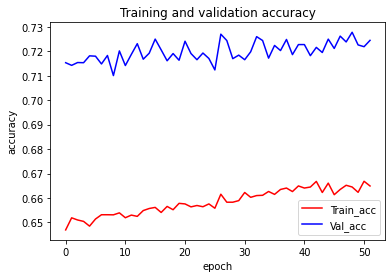

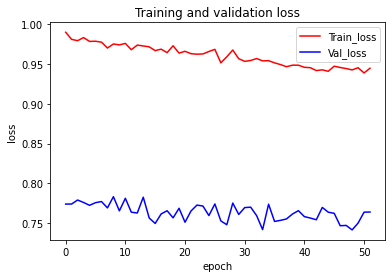

In [ ]:

#Graphing our training and validation
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Train_acc')
plt.plot(epochs, val_acc, 'b', label='Val_acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Train_loss')
plt.plot(epochs, val_loss, 'b', label='Val_loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
prediction=np.round(model.predict(validation_generator),0)
print('data', prediction)

data [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
validation_labels = validation_generator.classes 
 
# convert the training labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [ ]:
categorical_validation_labels = pd.DataFrame(validation_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(prediction).idxmax(axis=1)
cm= confusion_matrix(categorical_validation_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print("Normalized confusion matrix")
   else:
     print('Confusion matrix, without normalization')

 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label') 

Normalized confusion matrix


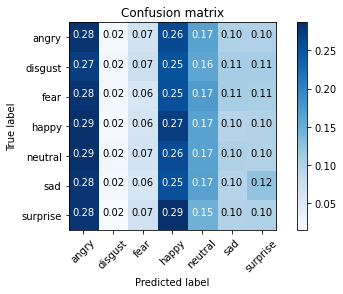

In [ ]:
plot_confusion_matrix(cm, ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], normalize=True)